# Библиотеки

In [1]:
import numpy as np 
import pandas as pd 
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score

import warnings
warnings.filterwarnings("ignore")

# Загрузка и преобразование данных

In [2]:
data = pd.read_csv('train data.csv')
data.head(5)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,M,62,Y,Y,0,0,1,1,2,18000,N,0
1,63161,SCH,F,59,N,N,0,0,3,2,3,19000,N,0
2,25887,SCH,M,25,Y,N,2,0,1,1,2,30000,Y,0
3,16222,SCH,F,53,N,N,0,0,2,2,3,10000,N,0
4,101655,GRD,M,48,N,N,0,1,1,2,3,30000,Y,0


In [3]:
data.shape

(73799, 14)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


In [5]:
# Рассмотрим пропуски в данных
data.isnull().sum()

client_id             0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
bki_request_cnt       0
home_address          0
work_address          0
income                0
foreign_passport      0
default               0
dtype: int64

In [6]:
# Пропуски есть только признаке education, заменим их значением Unknown
data['education'] = data['education'].fillna('Unknown')

In [7]:
# Проверим данные на наличие дублирующихся строк
duplicate_rows_data = data[data.duplicated()]
print('Number of duplicate rows: ', duplicate_rows_data.shape[0])

Number of duplicate rows:  0


In [8]:
# Отсортируем признаки на числовые, категориальные и бинарные

#бинарные переменные 
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

#категориальные переменные
cat_cols = ['education', 'work_address', 'home_address']

#числовые переменные
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

In [9]:
# Отобразим каждое значение категории в уникальное число для бинарных и категориальных признаков
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
columns = ['work_address', 'home_address']

for column in columns:
    data[column] = label_encoder.fit_transform(data[column])

In [10]:
# Для колонки education создадим категориальный признак с помощью one-hot-кодирования
data = pd.get_dummies(data, columns=['education'])

In [11]:
# Проверим сбалансированность классов
count_no_def = len(data[data['default']==0])
count_def = len(data[data['default']==1])
pct_of_no_def = count_no_def/(count_no_def+count_def)
print("percentage of no default is", pct_of_no_def*100)
pct_of_def = count_def/(count_no_def+count_def)
print("percentage of subscription", pct_of_def*100)

percentage of no default is 87.3006409300939
percentage of subscription 12.699359069906096


# Очистка данных и выбор признаков

In [12]:
train, validation = train_test_split(data, test_size=0.33, random_state=42)

Рассмотрим распределение числовых признаков. Так как у некоторых признаков в распределении есть большие перепады, возьмем от всех признаков натуральный логарифм.

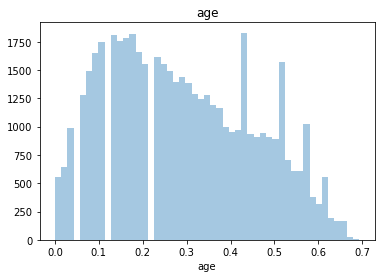

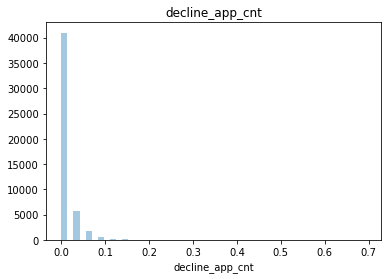

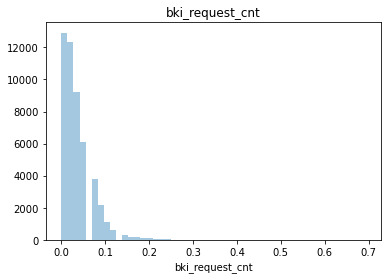

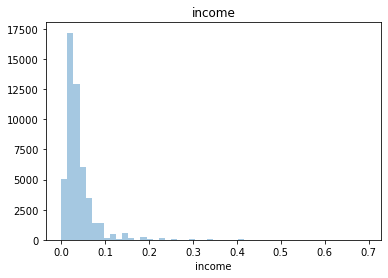

In [13]:
# Нормализуем признаки
for column in num_cols:
    train[column]=(train[column]-train[column].min())/(train[column].max()-train[column].min())
# Логарифмируем    
for column in num_cols:
    train[column] = train[column].apply(lambda w: np.log(w+1))
    
# Строим распределение
for i in num_cols:
    plt.figure()
    sns.distplot(train[i], kde = False, rug=False)
    plt.title(i)
    plt.show()

Данные признака decline_app_cnt в основном содержат нули, имеет смысл перевести признак в категориальный.

In [14]:
train['decline_app_cnt'] = train['decline_app_cnt'].apply(lambda x: 0.0 if x == 0.0 
                                                                    else 1.0 if x <= 0.087011 
                                                                    else 2.0 if x > 0.087011 else x)

Рассмотрим выбросы в данных.

In [15]:
def outliers(col):
    '''Функция предназначена для выявления выбросов в числовых переменных'''
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    f = Q1 - 1.5*IQR
    l = Q3 + 1.5*IQR
    
    list_for_outliers = []
    num = 1
    for i in col:
        if (i > l) or (i < f):
            list_for_outliers.append(1)
        else:
            list_for_outliers.append(0)
    
    if num in list_for_outliers:
        return list_for_outliers
    else: 
        return 'no outliers'
    
outliers_age = outliers(train['age'])
lst_outliers_req = outliers(train['bki_request_cnt'])
lst_outliers_inc = outliers(train['income'])

In [16]:
# Создадим новые признаки, отображающие выбросы в данных
train['bki_request_cnt_outl'] = lst_outliers_req
train['income_outl'] = lst_outliers_inc

In [17]:
# Заменим выбросы в данных
def rep_outliers(col):
    '''Функция предназначена для замены выбросов в числовых переменных'''
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    f = Q1 - 1.5*IQR
    l = Q3 + 1.5*IQR

    outliers = (col < f) | (col > l)

    col = col.copy()
    col.loc[col < f] = col.loc[~outliers].min()
    col.loc[col > l] = col.loc[~outliers].max()

    return col

cols = ['income', 'bki_request_cnt']

for i in cols:
    train[i] = rep_outliers(train[i])

In [18]:
num_cols = ['age', 'bki_request_cnt', 'income']
cat_cols = ['work_address', 'home_address', 'decline_app_cnt']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'education_ACD', 'education_GRD', 
            'education_PGR', 'education_SCH', 'education_UGR', 'education_Unknown',
            'bki_request_cnt_outl', 'income_outl']

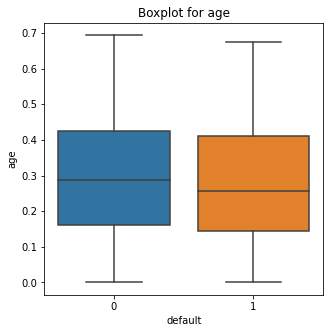

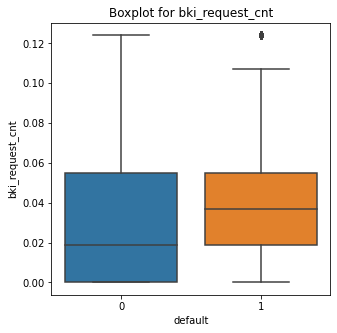

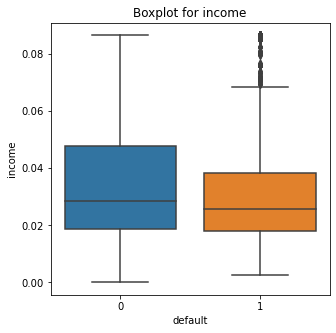

In [19]:
def get_boxplot(column):
    '''Функция предназначена для построения боксплота от целевой переменной'''
    fig, ax = plt.subplots(figsize = (5,5))
    sns.boxplot(x='default', y=column, data=train, ax=ax)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    
for col in num_cols:
    get_boxplot(col)

Дефолтные клиенты в среднем немного младше. Дефолтные клиенты в среднем имеют больше запросов в БКИ. Дефолтные клиенты в среднем имеют более низкий доход.

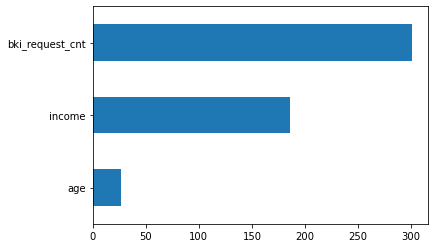

In [20]:
# Оценка значимости численных переменных
imp_num = pd.Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Из числовых признаков наименьшую значимость имеет признак возраста.

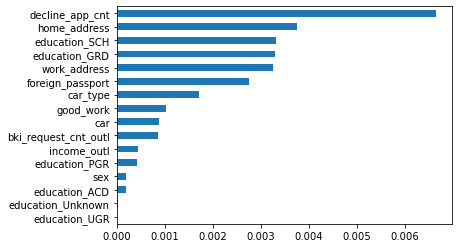

In [21]:
# Оценка значимости категориальных признаков
imp_cat = pd.Series(mutual_info_classif(train[bin_cols + cat_cols], train['default'],
                                     discrete_features = True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Из бинарных и категориальных наименее значимыми являются пропуски в колонке education, education_UGR, education_ACD и sex.

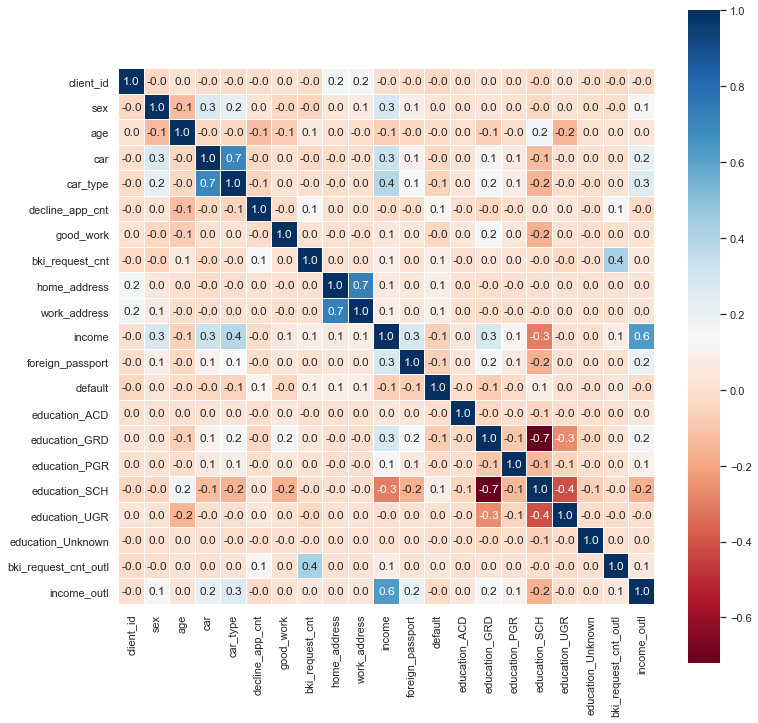

In [22]:
# Сделаем проверку на мультиколлинеарность. 
# Для этого построим матрицу корреляций для признаков:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(train.corr(), square=True, annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

Из корреляционной таблицы видно, что коррелируют признаки work_address и home_address, сильная корреляция также есть между признаками car и car_type, между education_SCH и education_GRD, и между income и income_outl. С целевой переменной больше всего коррелируют признаки car_type, decline_app_cnt, bki_request_cnt, work_address и home_address, foreign_passport, income, education_GRD и education_SCH.
Очевидно, что линейно зависимые и наименее значимые признаки нужно удалить из датасета, но перед этим проанализируем некоторые малозначимые признаки графически.

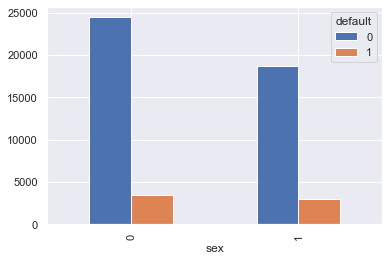

In [23]:
pd.crosstab(train.sex,train.default).plot(kind='bar')

В данных пол не сбалансирован, что отражается на графике, отличия между полами в случае дефолта минимально.

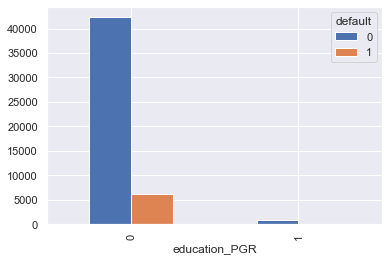

In [24]:
pd.crosstab(train.education_PGR,train.default).plot(kind='bar')

In [25]:
default_group = train.groupby('default')
default_group.education_PGR.value_counts(normalize = True)

default  education_PGR
0        0                0.981824
         1                0.018176
1        0                0.992079
         1                0.007921
Name: education_PGR, dtype: float64

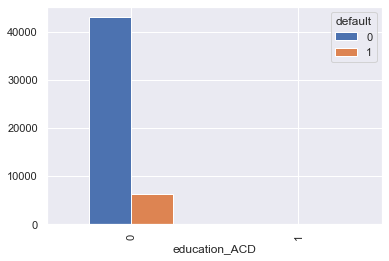

In [26]:
pd.crosstab(train.education_ACD,train.default).plot(kind='bar')

In [27]:
default_group.education_ACD.value_counts(normalize = True)

default  education_ACD
0        0                0.997079
         1                0.002921
1        0                0.999525
         1                0.000475
Name: education_ACD, dtype: float64

В случае характеристик education_PGR и education_ACD, в данных присутствет очень сильный перевес, поэтому оставим только один из этих признаков.

In [28]:
# Исходя из анализа выше, удалим признаки, которые имеют наименьшую значимость или имеют линейную зависимость.
train.drop(['client_id', 'car', 'work_address', 'education_UGR', 'education_ACD', 'education_Unknown',
            'income_outl'], axis = 1, inplace=True)

In [29]:
train.columns

Index(['sex', 'age', 'car_type', 'decline_app_cnt', 'good_work',
       'bki_request_cnt', 'home_address', 'income', 'foreign_passport',
       'default', 'education_GRD', 'education_PGR', 'education_SCH',
       'bki_request_cnt_outl'],
      dtype='object')

In [30]:
num_cols = ['age', 'bki_request_cnt', 'income']
cat_cols = ['home_address', 'decline_app_cnt']
bin_cols = ['sex', 'car_type', 'good_work', 'foreign_passport', 'education_GRD', 
            'education_PGR', 'education_SCH', 'bki_request_cnt_outl']

In [31]:
# Воспользуемся dummy-кодированием для категориальных переменных 
for column in cat_cols:
    train = pd.get_dummies(train, columns=[column])

In [32]:
# Стандартизация числовых переменных
scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])

In [33]:
# Делаем те же манипуляции с тестовыми данными
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

for column in num_cols:
    validation[column]=(validation[column]-validation[column].min())/(validation[column].max()-validation[column].min())

for column in num_cols:
    validation[column] = validation[column].apply(lambda w: np.log(w+1))
    
validation['decline_app_cnt'] = validation['decline_app_cnt'].apply(lambda x: 0.0 if x == 0.0 
                                                                    else 1.0 if x <= 0.117783 
                                                                    else 2.0 if x > 0.117783 else x)

validation['bki_request_cnt_outl'] = outliers(validation['bki_request_cnt'])
validation['income_outl'] = outliers(validation['income'])

cols = ['income', 'bki_request_cnt']
for i in cols:
    validation[i] = rep_outliers(validation[i])

validation.drop(['client_id', 'car', 'work_address', 'education_UGR', 'education_ACD', 'education_Unknown',
                 'income_outl'], axis = 1, inplace=True)

cat_cols = ['home_address', 'decline_app_cnt']
for column in cat_cols:
    validation = pd.get_dummies(validation, columns=[column])

# Стандартизация числовых переменных
num_cols = ['age', 'bki_request_cnt', 'income']
validation[num_cols] = scaler.transform(validation[num_cols])

# Построение модели

In [34]:
y = train['default'].values  
X = train.drop(['default'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_validation = validation.drop(['default'], axis=1)
y_true = validation['default'] 

In [35]:
X_train.shape, X_validation.shape, y_train.shape, y_true.shape

((39556, 17), (24354, 17), (39556,), (24354,))

In [36]:
model = LogisticRegression(solver = 'liblinear', C = 1.0, max_iter= 1000) 
model.fit(X_train,y_train)
y_pred = model.predict(X_validation)

In [37]:
y_probs = model.predict_proba(X_validation)[:,1]

In [38]:
confusion_matrix(y_true, y_pred)

array([[21277,    17],
       [ 3051,     9]], dtype=int64)

In [39]:
# метрики качества
def print_logisitc_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'acc = {acc:.3f} F1-score = {f1:.3f} prec = {prec:.2f} rec = {rec:.2f}')
print_logisitc_metrics(y_true, y_pred)

acc = 0.874 F1-score = 0.006 prec = 0.35 rec = 0.00


In [40]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.87      1.00      0.93     21294
     class 1       0.35      0.00      0.01      3060

    accuracy                           0.87     24354
   macro avg       0.61      0.50      0.47     24354
weighted avg       0.81      0.87      0.82     24354



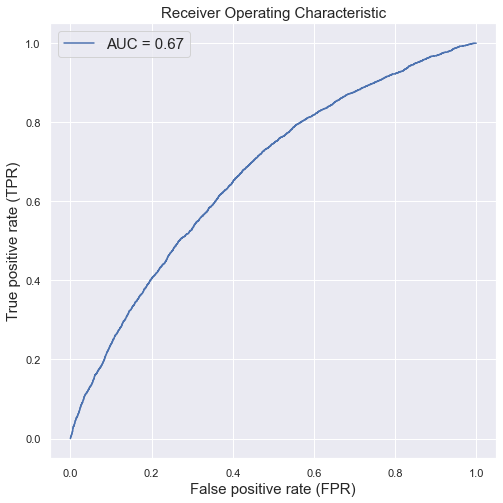

In [41]:
# Отрисовать ROC кривую
def calc_and_plot_roc(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.title('Receiver Operating Characteristic', fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15)
# Вычислить вероятности принадлежности классу 1 для каждого объекта из валидационной выборки
calc_and_plot_roc(y_true, y_probs)

In [112]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model_op = LogisticRegression()

iter_ = 500
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

## model ваша модель логистической регрессии
gridsearch = GridSearchCV(model_op, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

## печатаем параметры
best_parameters = model_op.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

	C: 1.0
	class_weight: None
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 100
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: None
	solver: 'lbfgs'
	tol: 0.0001
	verbose: 0
	warm_start: False


In [42]:
model = LogisticRegression(solver='sag', penalty='l2', class_weight='balanced', C = 1.0, max_iter=100,
                           multi_class='ovr', tol=0.001) 
model.fit(X_train,y_train)
y_pred = model.predict(X_validation)

In [43]:
y_probs = model.predict_proba(X_validation)[:,1]

In [44]:
confusion_matrix(y_true, y_pred)

array([[12690,  8604],
       [ 1056,  2004]], dtype=int64)

In [45]:
print_logisitc_metrics(y_true, y_pred)

acc = 0.603 F1-score = 0.293 prec = 0.19 rec = 0.65


In [46]:
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.92      0.60      0.72     21294
     class 1       0.19      0.65      0.29      3060

    accuracy                           0.60     24354
   macro avg       0.56      0.63      0.51     24354
weighted avg       0.83      0.60      0.67     24354



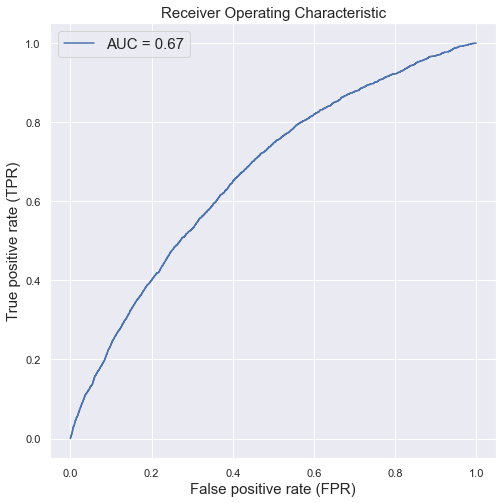

In [47]:
calc_and_plot_roc(y_true, y_probs)

# Вывод

В ходе выполнения проекта были изучены новые возможности библиотеки sklearn, такие как LabelEncoder и mutual_info_classif, что позволяет очистить данные от ненужных признаков и повысить предсказательную способность. 
* Была проведена очистка данных от пропущенных значений и выбросов, на основе которых были созданы новые признаки. 
* С помощью LabelEncoder, mutual_info_classif и корреляционной матрицы были отобраны признаки, наиболее сильно влияющие на предсказательную способность модели.
* С помощью GridSearchCV были подобраны оптимальные гиперпараметры модели и рассчитаны основые метрики.
* Была проведена попытка улучшить модель с помощью SMOTE, но модель хуже справлялась с ошибкой второго рода.
* На кагл оценка f-score получилась 0.34357, здесь, без дополнительных признаков, 0.293. 